# PATH & Hyperparameter Setting

In [1]:
import os
os.chdir('/root/')

In [2]:
## Setting parameters
max_len = 256
batch_size = 256
warmup_ratio = 0.1
num_epochs = 200
max_grad_norm = 1
log_interval = 200
learning_rate =  0.0005

In [3]:
!git clone https://github.com/jo1132/HappynJoy.git

Cloning into 'HappynJoy'...
remote: Enumerating objects: 5086, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 5086 (delta 0), reused 3 (delta 0), pack-reused 5083
Receiving objects: 100% (5086/5086), 409.27 MiB | 10.26 MiB/s, done.
Resolving deltas: 100% (57/57), done.
Updating files: 100% (5061/5061), done.
Error downloading object: KEMDy19/ECG/Session01/Original/Sess01F.csv (aab14b0): Smudge error: Error downloading KEMDy19/ECG/Session01/Original/Sess01F.csv (aab14b000d970fbd9b0be6cff28c263e5665b325ee13c062115c7fba9d6b2079): batch response: This repository is over its data quota. Account responsible for LFS bandwidth should purchase more data packs to restore access.

Errors logged to /root/HappynJoy/.git/lfs/logs/20230412T043052.454661909.log
Use `git lfs logs last` to view the log.
error: external filter 'git-lfs filter-process' failed
fatal: KEMDy19/ECG/Session01/Original/Sess01F.csv: smudge filter lfs failed
You can inspect what was checked out with 'git status'


# 데이터 전처리
## 음성 및 텍스트파일 한곳에 몰아넣기

In [4]:
PATH = './HappynJoy'

In [10]:
import pandas as pd
import shutil
import os

# 파일 복사 (현재 경로, 복사할 경로)
def CopyFile(cur_path, copy_path):
    shutil.copy(cur_path, copy_path)
    

# 재귀적으로 파일 탐색(현재 경로, 복사할 경로, 파일의 태그(종류, wav, EDA ....))
def SearchFiles(path, copy_path, tagname):
    for cur in os.listdir(path):
        cur_path = os.path.join(path, cur)
        if os.path.isdir(cur_path):
            SearchFiles(cur_path, copy_path, tagname)
        else:
            CopyFile(cur_path, os.path.join(copy_path, tagname+'_'+cur))


In [11]:
# 복제할 경로지정
COPY_PATH = os.path.join(PATH, "TOTAL")
os.makedirs(COPY_PATH, exist_ok=True)


for Ori in ["KEMDy19", "KEMDy20"]:
    for cur in os.listdir(os.path.join(PATH, Ori)):
        cur_path = os.path.join(PATH, Ori, cur)
        SearchFiles(cur_path, COPY_PATH, cur)

## DataFrame으로 정리하기

### ["KEMDy19", "KEMDy20"] 합치기

In [12]:
# DataFrame 세팅
def cut_df(df, filter_cols):
    df = df.iloc[1:]
    
    columns = []
    for item in df.columns:
        if item[:4] == "Eval":
            columns.append(item)
    temp = df[columns]
    
    
    
    temp['Emotion'] = ''*len(temp)
    for i in range(len(temp)):
        temp['Emotion'].iloc[i] = temp[columns].iloc[i].values
    
    df['Total Evaluation'] = temp['Emotion']
    df['index'] = df['Segment ID']
    df = df.set_index(['index'])
    df = df[filter_cols]
    df.columns = ['Segment ID', 'Emotion', 'Valence', 'Arousal']
    
    
    return df

# KEMDy19 데이터셋 합치기
def merge_data(F, M, neutral=True):
    aro = 0
    vals = 0
    
    if F['Segment ID'] != M['Segment ID']:
        print('ID diffrent Error', F['Segment ID'], M['Segment ID'])
        return pd.DataFrame(index=['Segment ID', 'Emotion', 'Valence', 'Arousal']).T
        
    ID = F['Segment ID']
    
    vals = (float(F['Valence']) + float(M['Valence'])) / 2
    aro = (float(F['Arousal']) + float(M['Arousal'])) / 2

    emo = F['Emotion'].tolist() + M['Emotion'].tolist()

    return pd.DataFrame([ID, emo, vals, aro], index=['Segment ID', 'Emotion', 'Valence', 'Arousal']).T

# Emotion 정리
def Emotion_Setting(x):
    #print(x)
    labeling = {
        'fear' : 0,
        'surprise' : 1,
        'angry' : 2,
        'sad' : 3,
        'neutral' : 4,
        'happy' : 5,
        'disgust' : 6,
    }
    
    dic = {i : 0  for i in range(len(labeling.keys()))}
    for emo in x:
        key = labeling[emo]
        dic[key] += 1    
    
    arr = []
    arr_sum = sum(dic.values())
    for v in dic.values():
        v = v/arr_sum
        arr.append(v)
    return arr

In [13]:
# 아까 모아놓았던 경로
#PATH = COPY_PATH
df = pd.DataFrame(columns=['Segment ID', 'Emotion', 'Valence', 'Arousal'])

cols1 = ['Segment ID', 'Total Evaluation', ' .1', ' .2']
cols2 = cols1.copy()
cols2[2] = 'Unnamed: 11'
cols2[3] = 'Unnamed: 12'

for i in range(1, 3+1):
    # 각 csv파일 읽고 컬럼 정리 및 이름 변경
    df1 = cut_df(pd.read_csv(os.path.join(COPY_PATH, "annotation_Sess{0:02d}_eval.csv".format(i))), cols1)
    df2 = cut_df(pd.read_csv(os.path.join(COPY_PATH, "annotation_Session{0:02d}_F_res.csv".format(i))), cols2)
    df3 = cut_df(pd.read_csv(os.path.join(COPY_PATH, "annotation_Session{0:02d}_F_res.csv".format(i))), cols2)

    # 파일 합치기 
    for i in range(len(df2)):
        df = pd.concat([df, merge_data(df2.iloc[i], df3.iloc[i])], axis=0)
    df = pd.concat([df, df1], axis=0)

df['Emotion'] = df['Emotion'].apply(Emotion_Setting)
df = df.sort_values(by=['Segment ID'])
df = df.reset_index().drop(labels=['index'], axis=1)
df.head(10)

/tmp/ipykernel_17546/4252171822.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Emotion'] = ''*len(temp)
/tmp/ipykernel_17546/4252171822.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Emotion'].iloc[i] = temp[columns].iloc[i].values
/tmp/ipykernel_17546/4252171822.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Emotion'].iloc[i] = temp[columns].i

,Segment ID,Emotion,Valence,Arousal
0,Sess01_impro01_F001,"[0.0, 0.0, 0.1, 0.0, 0.9, 0.0, 0.0]",2.7,2.7
1,Sess01_impro01_F002,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",2.9,3.1
2,Sess01_impro01_F003,"[0.0, 0.0, 0.1, 0.0, 0.7, 0.0, 0.2]",3.2,2.8
3,Sess01_impro01_F004,"[0.0, 0.0, 0.1, 0.0, 0.5, 0.0, 0.4]",3.1,2.9
4,Sess01_impro01_F005,"[0.0, 0.0, 0.3, 0.0, 0.3, 0.0, 0.4]",2.0,2.9
5,Sess01_impro01_F006,"[0.0, 0.0, 0.4, 0.0, 0.3, 0.0, 0.3]",2.0,2.9
6,Sess01_impro01_F007,"[0.0, 0.0, 0.3, 0.0, 0.2, 0.1, 0.4]",2.7,2.9
7,Sess01_impro01_F008,"[0.0, 0.0, 0.5, 0.0, 0.1, 0.1, 0.3]",2.2,3.2
8,Sess01_impro01_F009,"[0.0, 0.0, 0.7, 0.0, 0.2, 0.0, 0.1]",1.9,2.9
9,Sess01_impro01_F010,"[0.0, 0.0, 0.9, 0.0, 0.0, 0.0, 0.1]",1.9,3.1


### Label 속성 만들기

In [14]:
label = []
for item in df['Emotion'].values:
    max_val = 0
    max_key = -1
    for k, v in enumerate(item):
        if max_val < v:
            max_val = v
            max_key = k
    label.append(max_key)

df['label'] = label
df.head(10)

,Segment ID,Emotion,Valence,Arousal,label
0,Sess01_impro01_F001,"[0.0, 0.0, 0.1, 0.0, 0.9, 0.0, 0.0]",2.7,2.7,4
1,Sess01_impro01_F002,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",2.9,3.1,4
2,Sess01_impro01_F003,"[0.0, 0.0, 0.1, 0.0, 0.7, 0.0, 0.2]",3.2,2.8,4
3,Sess01_impro01_F004,"[0.0, 0.0, 0.1, 0.0, 0.5, 0.0, 0.4]",3.1,2.9,4
4,Sess01_impro01_F005,"[0.0, 0.0, 0.3, 0.0, 0.3, 0.0, 0.4]",2.0,2.9,6
5,Sess01_impro01_F006,"[0.0, 0.0, 0.4, 0.0, 0.3, 0.0, 0.3]",2.0,2.9,2
6,Sess01_impro01_F007,"[0.0, 0.0, 0.3, 0.0, 0.2, 0.1, 0.4]",2.7,2.9,6
7,Sess01_impro01_F008,"[0.0, 0.0, 0.5, 0.0, 0.1, 0.1, 0.3]",2.2,3.2,2
8,Sess01_impro01_F009,"[0.0, 0.0, 0.7, 0.0, 0.2, 0.0, 0.1]",1.9,2.9,2
9,Sess01_impro01_F010,"[0.0, 0.0, 0.9, 0.0, 0.0, 0.0, 0.1]",1.9,3.1,2


### 감정 데이터 분포 확인

{4: 1483, 6: 26, 2: 226, 1: 137, 3: 140, 0: 136, 5: 314}


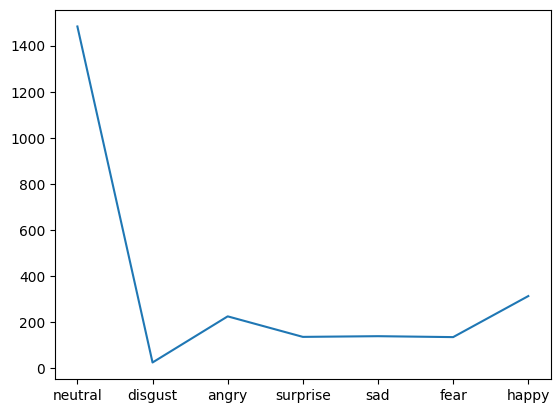

In [15]:
import matplotlib.pyplot as plt
count = {}

for i in range(len(df)):
  max_key = 0
  max_val = 0
  for key, val in enumerate(df.iloc[i]['Emotion']):
    if max_val < val:
      max_val = val
      max_key = key
  count[max_key] = count.get(max_key, 0) + 1
print(count)

labeling = {0: 'fear',
            1: 'surprise',
            2: 'angry',
            3: 'sad',
            4: 'neutral',
            5: 'happy',
            6: 'disgust'}

keys = [labeling[k] for k in count.keys()]
plt.plot(keys, count.values())

### Script 붙이기

In [16]:
def Read_txt(path):
    script = ''
    if os.path.isfile(path):
        try:
            with open(path, 'rt', encoding='CP949') as file:
                script = file.read()
        except:
            with open(path, 'rt', encoding='UTF-8') as file:
                script = file.read()
    else:
        print('No file', path)
    
    return script

In [17]:
df['Script'] = [0]*len(df)

for idx in range(len(df)):
    if type(df.iloc[idx]['Segment ID']) == str:
        SegID = "wav_"+df.iloc[idx]['Segment ID']
        file_name = SegID+'.txt'
        df['Script'].iloc[idx] = Read_txt(os.path.join(COPY_PATH, file_name))
    else:
        print(df.iloc[idx]['Segment ID'])
        df = df.drop(idx, axis=0)
        
df.to_csv(os.path.join(PATH, 'merged_data.csv'), encoding="utf-8-sig", index=False)
df.head(20)

/tmp/ipykernel_17546/2373349012.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Script'].iloc[idx] = Read_txt(os.path.join(COPY_PATH, file_name))


No file ./HappynJoy/TOTAL/wav_Sess03_script04_M016.txt


,Segment ID,Emotion,Valence,Arousal,label,Script
0,Sess01_impro01_F001,"[0.0, 0.0, 0.1, 0.0, 0.9, 0.0, 0.0]",2.7,2.7,4,한번 드셔보세요. 맛있을 거에요.\n
1,Sess01_impro01_F002,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",2.9,3.1,4,된장베이스로 남녀노소 좋아할 거 같구요. 뭐 파랑 향을 익혀서 좀 고급진 맛을 더했...
2,Sess01_impro01_F003,"[0.0, 0.0, 0.1, 0.0, 0.7, 0.0, 0.2]",3.2,2.8,4,"아니, 한국 사람이면 된장 다 좋아하지 않아요?\n"
3,Sess01_impro01_F004,"[0.0, 0.0, 0.1, 0.0, 0.5, 0.0, 0.4]",3.1,2.9,4,라면이잖아요. 라면 안 좋아하는 애들 봤어요?\n
4,Sess01_impro01_F005,"[0.0, 0.0, 0.3, 0.0, 0.3, 0.0, 0.4]",2.0,2.9,6,b/ 진짜 말을 말아야지. 일본은 미소에요. 미소와 된장은 엄연히 다릅니다. 그런 ...
5,Sess01_impro01_F006,"[0.0, 0.0, 0.4, 0.0, 0.3, 0.0, 0.3]",2.0,2.9,2,"어디서 뭐 잡지식이나 주워들어왔는지 모르겠는데, 저기요. 저 여기 스파주방장입니다.\n"
6,Sess01_impro01_F007,"[0.0, 0.0, 0.3, 0.0, 0.2, 0.1, 0.4]",2.7,2.9,6,b/ 아 어디 가셨는지 모르겠지만 외국에도 라면이 있었나요?\n
7,Sess01_impro01_F008,"[0.0, 0.0, 0.5, 0.0, 0.1, 0.1, 0.3]",2.2,3.2,2,외국에서 그렇게 잘나가시는 분이 왜 들어오셨을까? 왜 한국으로 기어들어오셨을까? o...
8,Sess01_impro01_F009,"[0.0, 0.0, 0.7, 0.0, 0.2, 0.0, 0.1]",1.9,2.9,2,지금 당신이 말하는 바로는.\n
9,Sess01_impro01_F010,"[0.0, 0.0, 0.9, 0.0, 0.0, 0.0, 0.1]",1.9,3.1,2,"(아닙니까?+굉장히) 지금 위험한 발언을 하시는데, 그럼 지금 이사람들 바보로 지금..."


# Generate Dataset

## Import Audios

In [19]:
import torch
import torchaudio
import os

bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
wave_arr = []
for idx in range(len(df)):
    audio_path = os.path.join(COPY_PATH, 'wav_'+df['Segment ID'].iloc[idx]+'.wav')
    waveform, sample_rate = torchaudio.load(audio_path)

    if sample_rate != bundle.sample_rate:
        waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

    wave_arr.append(waveform)

df['Audio'] = wave_arr

df.tail()

,Segment ID,Emotion,Valence,Arousal,label,Script,Audio
2457,Sess03_script06_User006M_016,"[0.0, 0.1, 0.0, 0.0, 0.8, 0.0, 0.1]",2.8,3.1,4,근데 나도 생각해 보면은 수업 시간에 모자 쓰는 사람들 좀 이해 안 되기는 해.\n,"[[tensor(0.0023), tensor(0.0024), tensor(0.002..."
2458,Sess03_script06_User006M_017,"[0.0, 0.0, 0.0, 0.0, 0.8, 0.0, 0.2]",2.9,3.2,4,"아무래도 예의가 아니긴 하니까, 그런 거 생각했을 때 나도 꼰대인가 싶기도 하고.\n","[[tensor(-0.0097), tensor(-0.0100), tensor(-0...."
2459,Sess03_script06_User006M_018,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",2.9,3.2,4,근데 난 이제 이거를 입 밖으로 내뱉냐 아니면 생각만 하고 그냥 그렇게 넘어가느냐도...,"[[tensor(0.0115), tensor(0.0117), tensor(0.011..."
2460,Sess03_script06_User006M_019,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",2.9,2.8,4,"응, 그거는 예의에 차이겠지.\n","[[tensor(0.0040), tensor(0.0040), tensor(0.003..."
2461,Sess03_script06_User006M_020,"[0.0, 0.0, 0.0, 0.0, 0.9, 0.0, 0.1]",2.9,2.7,4,자기들도 그렇게 어어.\n,"[[tensor(0.0018), tensor(0.0012), tensor(0.001..."


## Text Tokenizing

In [20]:
from transformers import ElectraTokenizer
class KEMDyDataset():
  def __init__(self, dataframe, max_length):
    self.max_length = max_length
    self.dataset = dataframe.dropna(axis=0) 
    # 중복제거
    self.tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")

  
  def __len__(self):
    return len(self.dataset)
  
  def __getitem__(self, idx):
    row = self.dataset.iloc[idx].values
    text = row[0]
    y = row[2]

    inputs = self.tokenizer(
      text,
      return_tensors='pt',
      truncation=True,
      max_length=self.max_length,
      pad_to_max_length=True
    )
    
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]

    return [input_ids, attention_mask, row[1], y]

## Train Test Split

In [21]:
from sklearn.model_selection import train_test_split
data = df[['Script', 'Audio', 'Emotion']]
#label = df[['Emotion']]

train, test = train_test_split(data, train_size=0.8, random_state=123, shuffle=True)
print(len(train), len(test))

1969 493


## Generate Dataset

In [22]:

def DataLoader(dataset, batch_size):
  length = dataset.__len__()
  batch = []
  for i in range(0, length, batch_size):
    item = []
    for j in range(i, min(i + batch_size, length)):
      item.append(dataset.__getitem__(j)) 
    batch.append(item)
  return batch

In [23]:

train_dataset = KEMDyDataset(train, max_len)
test_dataset = KEMDyDataset(test, max_len)


train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

/usr/local/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [41]:
len(test_dataloader[0])

256

# Wav2Vec

In [14]:
import os
import IPython
import torch
import torchaudio

## Extract Feature

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model = bundle.get_model().to(device)

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth
100%|██████████| 360M/360M [00:33<00:00, 11.3MB/s] 


In [16]:
SPEECH_FILE = os.path.join(PATH, 'TOTAL', 'wav_'+df.iloc[0]['Segment ID']+'.wav')
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

with torch.inference_mode():
    features, _ = model.extract_features(waveform)

print(features[0].shape)

torch.Size([1, 155, 768])


# KElectra

## Import Libs

In [151]:
import torchaudio
import torch
from torch import nn

## Hyperparameter init
- 데이터셋에서 가장 긴 문장의 길이는 이었고, 이를 수용하기 위해 max_len을 256으로 했을 때, 모든 단어가 embedding될 수 있었다.

In [68]:
from transformers import ElectraModel, ElectraTokenizer
model = ElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator")  # KoELECTRA-Base-v3
tokenizer_elc = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")
#tok = tokenizer_elc.tokenize("[CLS] 한국어 ELECTRA를 공유합니다. [SEP]")
tok = tokenizer_elc(
  max_sentence,
  return_tensors='pt',
  truncation=True,
  max_length=max_len,
  pad_to_max_length=True
).to(device)
#print(tok)
#ids = tokenizer_elc.convert_tokens_to_ids(tok)
ids = tok
print(ids)

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


{'input_ids': tensor([[    2,  2279,    16, 20981,  5158,  4576,  6216,    18,  2126,  6450,
          4076,  4212,  4048,  6395,  7226,  4073,  6963, 29365,  4062,  4395,
          3288,  4070,  3176, 18781,    16,  6678,  4073,  4129,  3288,  4070,
         11421,  6244,  4311,  4083,  4006,  4292,  9914,  7887,  4219,  3249,
          4292,  2468,  2489,  6678,  4073,  4129,  2631,  4112,  3311,  4112,
          2048,  4006,  6844,  4200,  3083,  4494,  5012,  4576,  6390,    35,
          6353,  4006, 29977,  9448,  3240,  6244,  4073,  4129,  9914,  2489,
         21143,  4108,  4031,  6628,  3240,  6244,  4311,  4083,  4007,  6287,
          4199, 10749, 12051,  4073, 19272,  2967,  3249,  4176,  6594,  4006,
          3288,  4070,  6493,  6459,  8801,  4031,  6628,  3176,  4576,  6216,
            18,  6890,    16,  6292,  6590,  4279,  5240,  5151,  4007,  6244,
          4112,  6299,  8667,  4234,  3865,  4007,  6289,  4279,  7218,  9762,
            18,  6450,  4076,  4212, 2

In [69]:
#ids = torch.as_tensor(ids)
kelec_embedding = nn.Sequential(model.embeddings).to(device)
feature = kelec_embedding(ids['input_ids'])
print(feature.shape)
print(feature)

torch.Size([1, 256, 768])
tensor([[[-0.0299,  0.2201,  0.0431,  ...,  0.2753, -0.1463, -0.5231],
         [-0.5235,  0.6493,  0.4066,  ...,  0.4894, -0.0379,  0.1008],
         [-0.5008,  0.0591, -0.1869,  ..., -0.2658, -0.0362,  0.4281],
         ...,
         [ 0.1935, -0.2342,  0.1181,  ...,  0.1228,  0.2264,  0.0245],
         [ 0.1389, -0.2933,  0.1595,  ...,  0.2741,  0.1126,  0.3081],
         [ 0.1431, -0.5462,  0.0169,  ...,  0.1753,  0.2385, -0.0042]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)


In [ ]:

for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
  token_ids = token_ids.long().to(device)
  segment_ids = segment_ids.long().to(device)
  valid_length= valid_length
  out = bert_embedding(token_ids)
  break

print(out.shape)

# Multimodal Transformer

### Import Libs

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np

import random
import math
import time

### ours

In [47]:
class Ours_Model(nn.Module):
    def __init__(self, 
                 audio_encoder, 
                 text_encoder,
                 #decoder, 
                 src_pad_idx, 
                 #trg_pad_idx, 
                 hidden_size,
                 num_of_class,
                 device):
        super().__init__()
        self.audio_encoder = audio_encoder
        self.text_encoder = text_encoder
        #self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        #self.trg_pad_idx = trg_pad_idx
        self.device = device
        self.classifier = nn.Linear(hidden_size, num_of_class)

    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    '''
    def make_trg_mask(self, trg):
        #trg = [batch size, trg len]
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]
        trg_len = trg.shape[1]
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]
        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]
        return trg_mask
    '''
    def forward(self, audio_src, text_src):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        #src_mask = self.make_src_mask(src)
        #trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        aud_enc_src = self.audio_encoder(audio_src, text_src) 
        text_enc_src = self.text_encoder(audio_src, text_src)
        #enc_src, attention = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        #output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return self.classifier(enc_src)

### Encoder

In [78]:

class AudioQueryEncoder(nn.Module):
    def __init__(self, 
                 wav2vec2,
                 koelectra,
                 #koelectra_encoding,
                 #koelectra_embedding,
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        self.wav2vec2 = wav2vec2
        self.koelectra = koelectra

        ''' Input Embedding '''
        #self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        # <sos> token부터 문장의 최대 길이로 설정한 100까지 positional embedding을 함.
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        ''' Multiple Encoder '''
        # 논문에서는 N=6개의 encoder layer를 사용하였음
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    #def forward(self, src, src_mask):
    def forward(self, audio_src, text_src):   
        audio_src = self.wav2vec2(audio_src)
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        batch_size = audio_src.shape[0]
        src_len = audio_src.shape[1]
        #pos = [batch size, src len]
        audio_pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        text_src = self.koelectra(text_src[0]. text_src[1])
        batch_size = text_src.shape[0]
        src_len = text_src.shape[1]
        text_pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        # src 문장의 embedding vector와 positional vector를 더해줌
        #src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        audio_src = self.dropout((self.tok_embedding(audio_src) * self.scale) + self.pos_embedding(audio_pos))
        text_src = self.dropout((self.tok_embedding(text_src) * self.scale) + self.pos_embedding(text_pos))
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            #src = layer(src, src_mask)
            #src, attention = layer(src, src_mask)
            src, attention = layer(audio_src, text_src)
            
        #src = [batch size, src len, hid dim]
            
        return src, attention



### Text Encoder

In [79]:
class TextQueryEncoder(nn.Module):
    def __init__(self, 
                 wav2vec2,
                 koelectra,
                 #koelectra_encoding,
                 #koelectra_embedding,
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        self.wav2vec2 = wav2vec2
        self.koelectra_encoding = koelectra_encoding
        self.koelectra_embedding = koelectra_embedding
        ''' Input Embedding '''
        #self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        # <sos> token부터 문장의 최대 길이로 설정한 100까지 positional embedding을 함.
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        ''' Multiple Encoder '''
        # 논문에서는 N=6개의 encoder layer를 사용하였음
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    #def forward(self, src, src_mask):
    def forward(self, audio_src, text_src):   
        audio_src = self.wav2vec2(audio_src)
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        batch_size = audio_src.shape[0]
        src_len = audio_src.shape[1]
        #pos = [batch size, src len]
        audio_pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        text_src = self.koelectra_embedding(koelectra_encoding(text_src))
        batch_size = text_src.shape[0]
        src_len = text_src.shape[1]
        text_pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        # src 문장의 embedding vector와 positional vector를 더해줌
        #src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        audio_src = self.dropout((self.tok_embedding(audio_src) * self.scale) + self.pos_embedding(audio_pos))
        text_src = self.dropout((self.tok_embedding(text_src) * self.scale) + self.pos_embedding(text_pos))
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            #src = layer(src, src_mask)
            #src, attention = layer(src, src_mask)
            src, attention = layer(text_src, audio_src)
            
        #src = [batch size, src len, hid dim]
            
        return src, attention



### Encoder Layer

In [80]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        ''' Multi Head self-Attention '''        
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)

        ''' Positional FeedForward Layer'''
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)

        self.dropout = nn.Dropout(dropout)
        
    def forward(self, Q, K):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        V = K
        _src, attention = self.self_attention(Q, K, V)
        #_src = self.self_attention(src, src, src, src_mask)

        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #return src
        return src, attention

### Multi Head Attention Layer

In [81]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        # encoder의 Q, K, V는 모두 같은 space에서 옵니다.
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

### Position-wise Feedforward Layer

In [82]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

### Training the wave transformer

In [84]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
koelectra = ElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator")  # KoELECTRA-Base-v3
INPUT_DIM = len(test_dataloader[0])
#OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
NUM_OF_CLASS = 7
HID_SIZ = 768
ENC_LAYERS = 3
#DEC_LAYERS = 3
ENC_HEADS = 8
#DEC_HEADS = 8
ENC_PF_DIM = 512
#DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
#DEC_DROPOUT = 0.1

'''
def __init__(self, 
                 wav2vec2,
                 koelectra,
                 #koelectra_encoding,
                 #koelectra_embedding,
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
'''
Audio_enc = AudioQueryEncoder(
    wav2vec2,
    koelectra,
    #koelectra.encoder,
    #koelectra.embeddings,
    INPUT_DIM, 
    HID_DIM, 
    ENC_LAYERS, 
    ENC_HEADS, 
    ENC_PF_DIM, 
    ENC_DROPOUT,
    device)

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### Encoder

In [85]:
import torchaudio
import torch
from torch import nn
from transformers import ElectraModel

INPUT_DIM = len(test_dataloader[0])
#OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
NUM_OF_CLASS = 7
HID_SIZ = 768
ENC_LAYERS = 3
#DEC_LAYERS = 3
ENC_HEADS = 8
#DEC_HEADS = 8
ENC_PF_DIM = 512
#DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
#DEC_DROPOUT = 0.1

bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
wav2vec2 = bundle.get_model()
koelectra = ElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator")  # KoELECTRA-Base-v3

Audio_enc = AudioQueryEncoder(
    wav2vec2,
    koelectra,
    #koelectra.encoder,
    #koelectra.embeddings,
    INPUT_DIM, 
    HID_DIM, 
    ENC_LAYERS, 
    ENC_HEADS, 
    ENC_PF_DIM, 
    ENC_DROPOUT,
    device)
Text_enc = TextQueryEncoder(
    wav2vec2,
    koelectra,
    #koelectra.encoder,
    #koelectra.embeddings,
    INPUT_DIM, 
    HID_DIM, 
    ENC_LAYERS, 
    ENC_HEADS, 
    ENC_PF_DIM, 
    ENC_DROPOUT,
    device)
'''
enc = Encoder(INPUT_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT,
              device)
dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)
'''
model = Ours_Model(Audio_enc, Text_enc, SRC_PAD_IDX, HID_SIZ, NUM_OF_CLASS, device).to(device)

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


TypeError: empty() received an invalid combination of arguments - got (tuple, dtype=NoneType, device=NoneType), but expected one of:
 * (tuple of ints size, *, tuple of names names, torch.memory_format memory_format, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of ints size, *, torch.memory_format memory_format, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


#### Count Parameter

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

#### Initialize_weights

In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)

#### Optimizer & Criterion

In [ ]:
#learning_rate = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

#criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)
criterion = nn.CrossEntropyLoss()
#criterion = nn.MSELoss()

#### Train

##### DataPrepare

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        Audio_src = 
        text_src = 
        trg = batch['Emotion'].values
        
        optimizer.zero_grad()
        
        output, _ = model(audio_src, text_src)
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

#### Evaluation

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

#### Train the model through multiple epochs

In [ ]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')


for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

model.load_state_dict(torch.load('tut6-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')